# Setup

In [1]:
# import modules

import toolbox_morph
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import glob
import dynesty
from dynesty import plotting as dyplot


In [2]:
# define paths

path_main_directory = '/Users/sandrotacchella/ASTRO/SRMP/morph_project/'
path_SFH_table = path_main_directory + 'SFH/Behroozi+19/'


# Set up model

In [3]:
# set up radial bins of the models (don't use too many otherwise everything will be slow...)

radius_kpc = np.logspace(-1.0, 1.3, num=20)
print radius_kpc


[ 0.1         0.13214558  0.17462454  0.2307586   0.30493728  0.40296113
  0.53249531  0.703669    0.92986747  1.22877873  1.62377674  2.14574914
  2.83551258  3.74700446  4.95150067  6.54318913  8.64653503 11.42601361
 15.09897161 19.95262315]


In [4]:
# create list of SFH tables

list_SFH_tables = glob.glob(path_SFH_table + '*a1.002310.dat')

# just every second file in order to increases speed
list_SFH_tables = glob.glob(path_SFH_table + '*a1.002310.dat')[::2]

print(list_SFH_tables)
print(len(list_SFH_tables))


['/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.10_a1.002310.dat', '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.50_a1.002310.dat', '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.90_a1.002310.dat', '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm11.30_a1.002310.dat', '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm11.70_a1.002310.dat', '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm8.70_a1.002310.dat', '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.10_a1.002310.dat', '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.50_a1.002310.dat', '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.90_a1.002310.dat']
9


# Observations

In [5]:
# define size-mass relation from observations; these are the observations we want to fit

def Mosleh2013_SF(mass):
    alpha, beta, gamma, M0 = 0.109, 0.263, 10**-0.743, 10**10.204
    return(gamma*mass**alpha*(1+mass/M0)**(beta-alpha))

def Mosleh2013_Q(mass):
    alpha, beta, gamma, M0 = 0.014, 0.912, 10**-0.058, 10**10.555
    return(gamma*mass**alpha*(1+mass/M0)**(beta-alpha))


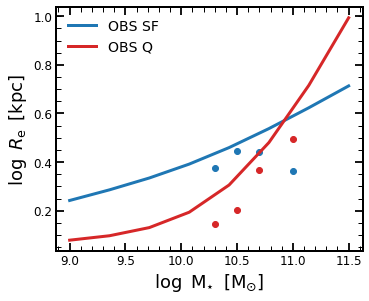

In [16]:
### IGNORE THIS ###
# we need to think of mass to light ratio correction (i.e. half mass vs half light sizes)

z_bin_OBS = np.array([1.75, 1.25, 0.75, 0.0])
M_bin_OBS = np.array([11.0, 10.7, 10.5, 10.3])

RM_Q = np.array([[0.99, 1.12, 1.88, 3.12], [0.58, 0.89, 1.22, 2.32], [0.48, 0.73, 1.21, 1.60], [0.44, 0.65, 0.93, 1.40]])
RM_SF = np.array([[1.70, 1.70, 2.11, 2.31], [1.77, 1.84, 1.83, 2.76], [1.94, 1.72, 1.83, 2.80], [2.05, 1.87, 2.27, 2.37]])


log_mass_plot = np.linspace(9.0, 11.5, num=8)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 4.5))

# plot observations
ax.plot(M_bin_OBS, np.log10(RM_SF[:, -1]), 'o', color='C0')
ax.plot(M_bin_OBS, np.log10(RM_Q[:, -1]), 'o', color='C3')
ax.plot(log_mass_plot, np.log10(Mosleh2013_SF(10**log_mass_plot)), '-', lw=3, color='C0', label='OBS SF')
ax.plot(log_mass_plot, np.log10(Mosleh2013_Q(10**log_mass_plot)), '-', lw=3, color='C3', label='OBS Q')

# set axes
ax.set_xlabel(r'$\log\/\/\/\mathrm{M_{\star}}\/\/\/[\mathrm{M_{\odot}}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/R_{\rm e}\/\/\/[\mathrm{kpc}]$', fontsize=18)

#ax.set_xlim([9.0, 11.5])
#ax.set_ylim([-0.3, 1.5])

ax.legend(frameon=False, fontsize=14, loc='upper left')

plt.show()


# Functions

In [10]:
def get_properties(redshift_in, alpha, beta, gamma, delta):
    '''
    This function returns masses and sizes for a given redshift and parameters.
    '''
    mass_Q_list = []
    mass_SF_list = []
    RM_Q_list = []
    RM_SF_list = []
    S1_Q_list = []
    S1_SF_list = []
    for SFH_file in list_SFH_tables:
        # read in table
        SFH_table = Table.read(SFH_file, format='ascii', names=('scale_factor', 'SFH_all', 'SFH_all_up', 'SFH_all_dw', 'SFH_SF', 'SFH_SF_up', 'SFH_SF_dw', 'SFH_Q', 'SFH_Q_up', 'SFH_Q_dw', 'SFH_Cen', 'SFH_Cen_up', 'SFH_Cen_dw', 'SFH_Sat', 'SFH_Sat_up', 'SFH_Sat_dw', 'scale_factor_begin', 'scale_factor_end')) 
        # set up galaxies (SF and Q) and get props
        gal_Q = toolbox_morph.galaxy(radius_kpc, SFH_table['scale_factor'], SFH_table['SFH_Q'], [alpha, beta, gamma, delta])
        gal_SF = toolbox_morph.galaxy(radius_kpc, SFH_table['scale_factor'], SFH_table['SFH_SF'], [alpha, beta, gamma, delta])
        RM_Q = gal_Q.get_size(redshift_in=redshift_in)
        RM_SF = gal_SF.get_size(redshift_in=redshift_in)
        #S1_Q = gal_Q.get_mass_within_R(Rmax=1.0, redshift_in=redshift_in)/np.pi
        #S1_SF = gal_SF.get_mass_within_R(Rmax=1.0, redshift_in=redshift_in)/np.pi
        mass_Q = gal_Q.get_mass_after_mass_loss(redshift_in=redshift_in)
        mass_SF = gal_SF.get_mass_after_mass_loss(redshift_in=redshift_in)
        # append
        mass_Q_list.append(mass_Q)
        mass_SF_list.append(mass_SF)
        RM_Q_list.append(RM_Q)
        RM_SF_list.append(RM_SF)
        #S1_Q_list.append(S1_Q)
        #S1_SF_list.append(S1_SF)
    # convert lists to arrays
    mass_Q_list = np.array(mass_Q_list)
    mass_SF_list = np.array(mass_SF_list)
    RM_Q_list = np.array(RM_Q_list)
    RM_SF_list = np.array(RM_SF_list)
    #S1_Q_list = np.array(S1_Q_list)
    #S1_SF_list = np.array(S1_SF_list)
    # sort
    s_Q = mass_Q_list.argsort()
    s_SF = mass_SF_list.argsort()
    return(mass_Q_list[s_Q], mass_SF_list[s_SF], RM_Q_list[s_Q], RM_SF_list[s_SF])


In [7]:
# define log-likelihood

def loglike(theta):
    a, b, c, d = theta
    mass_Q_z0, mass_SF_z0, RM_Q_z0, RM_SF_z0 = get_properties(0.0, a, b, c, d)
    R_obs_Q = np.log10(Mosleh2013_Q(mass_Q_z0))
    R_obs_SF = np.log10(Mosleh2013_SF(mass_SF_z0))
    data_minus_model_Q = R_obs_Q-np.log10(RM_Q_z0)
    data_minus_model_SF = R_obs_SF-np.log10(RM_SF_z0)
    inv_sigma2 = 1.0
    log_like = -0.5 * (np.sum(((data_minus_model_Q)**2 +(data_minus_model_SF)**2) * inv_sigma2 - np.log(inv_sigma2)))
    return(log_like)


In [8]:
# define prior transform

# alpha: normalization
# beta: mass dependence => (M/10**10)**beta
# gamma: sSFR dependence => ((SFR/M)/10**-10)**gamma
# delta: redshift dependence => (1+z)**delta

def prior_transform(utheta):
    """Transforms our unit cube samples 'u' to those from a flat prior
    between in each variable."""
    u_a, u_b, u_c, u_d = utheta
    a = 10. * u_a
    b = 3. * (2. * u_b - 1.)
    c = 3. * (2. * u_c - 1.)
    d = 3. * (2. * u_d - 1.)
    return a, b, c, d





In [11]:
# define the sampler, takes a couple of minutes

dsampler = dynesty.NestedSampler(loglike, prior_transform, ndim=4, nlive=100,
                                        bound='multi', sample='unif',
                                        first_update={'min_ncall': -np.inf, 'min_eff': np.inf},
                                        update_interval=0.5)


/Users/sandrotacchella/ASTRO/SRMP/morph_project/morph_tools/toolbox_morph.py:103: RuntimeWarning: divide by zero encountered in power
  self.Rs = self.Rs_params[0]*(self.mass/10**10)**self.Rs_params[1]*((self.SFR/self.mass)/10**-10)**self.Rs_params[2]*(1+self.redshift)**self.Rs_params[3]


In [12]:
# sample space, takes about 20-30 min

dsampler.run_nested(dlogz=0.5)


iter: 296+100 | bound: 11 | nc: 1 | ncall: 658 | eff(%): 60.182 | loglstar:   -inf < -0.210 <    inf | logz: -2.373 +/-  0.109 | dlogz:  0.005 >  0.500            

In [13]:
# get results

dres = dsampler.results


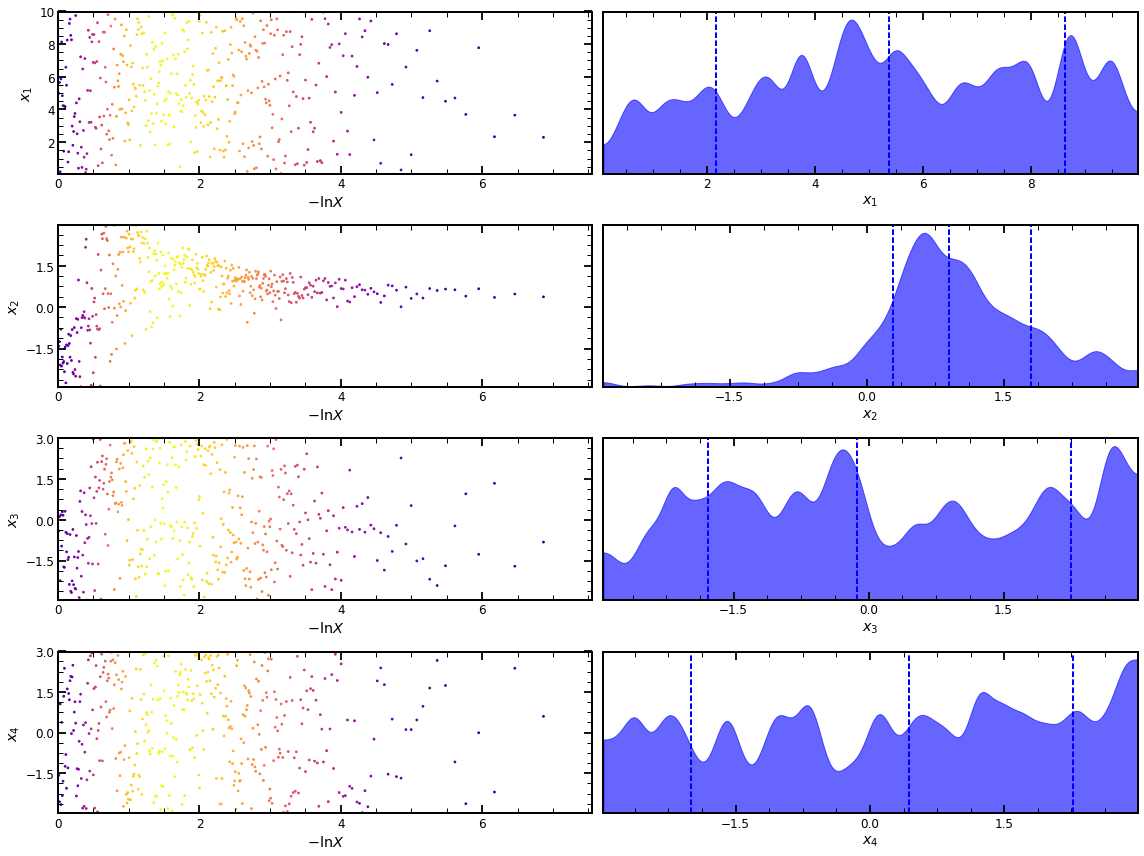

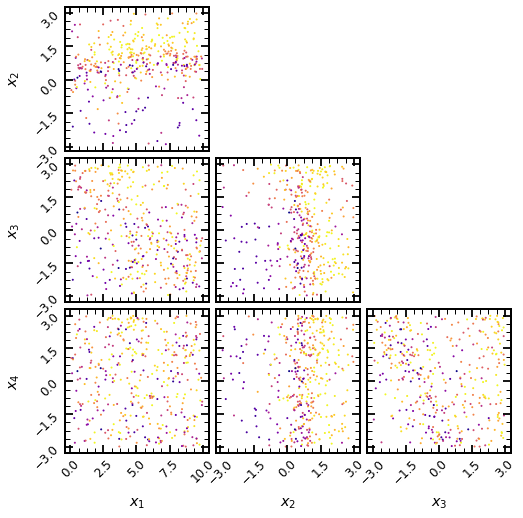

In [14]:
# plot results

# trace plot
fig, axes = dyplot.traceplot(dsampler.results, 
                             fig=plt.subplots(4, 2, figsize=(16, 12)))
fig.tight_layout()
plt.show()

# corner plot
fig, axes = dyplot.cornerpoints(dres)
plt.show()


In [ ]:
from dynesty import utils as dyfunc

samples, weights = res2.samples, np.exp(res2.logwt - res2.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)
